Drawing the corner from numpy.rec file. The benefit is that variable name is in file. Burnin is already applied.

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from read_files import *
from run_mcmc import HODParameter

In [7]:
with open('./configs/config_small_gaus_fsat.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
    # ========== reading configs ==========
    # don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
    available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                        'backend_file', 'numpy_file', 'wp_table_path', 'signal_path', 'module_path']
    Nwalkers = 40
    Nstep = 4000
    Nburnin = 300
    Npro = 40
    auto_range = None
    cross_range = None
    backend_file = ''
    numpy_file = ''
    wp_table_path = '../wp_table'
    signal_path = '../signal'
    module_path = './HOD/calc_wp.py'

    for k in available_fields:
        if k in other_configs:
            locals()[k] = other_configs[k]

    wp_table = read_wp(wp_table_path)
    rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
    cov = read_cov(signal_path + '/cov.npy')
    logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
    module = read_module(module_path)
    chi_2 = module.chi_2
    N_c = module.N_c
    # for better performance I would recommend setting these as global variable
    # ========== apply the fitting range ==========

    if auto_range or cross_range:
        if auto_range is None:
            auto_range = [0, len(rp_auto)]
        if cross_range is None:
            cross_range = [0, len(rp_cross)]
        l_a, r_a = auto_range[0], auto_range[1]
        l_c, r_c = cross_range[0], cross_range[1]

        auto_size = len(rp_auto)
        cross_size = len(rp_cross)
        rp_auto = rp_auto[l_a:r_a]
        rp_cross = rp_cross[l_c:r_c]
        signal_auto = signal_auto[l_a:r_a]
        signal_cross = signal_cross[l_c:r_c]

        cov = np.vstack((
            np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a])),
            np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]))
        ))

    signal = np.hstack((signal_cross, signal_auto))
    cov_inv = np.linalg.inv(cov)

    # ========== handle interpolating table ==========
    wp_table_auto = interpolate_table(wp_table, rp_auto)
    wp_table_cross = interpolate_table(wp_table, rp_cross)

    parameter = HODParameter.from_config(par_configs)
    print(parameter)

HODParameter(lgMmin:    14  [10~17]
             sig_lgM:   1   [0.001~3]
             Amp:       0.7 [fixed]
             fsat:      0.3 [0~1])


In [10]:
if not numpy_file.endswith('.npy'):
    numpy_file += '.npy'
result = np.load(numpy_file)
array_2d = result.view((np.float64, len(result.dtype.names)))

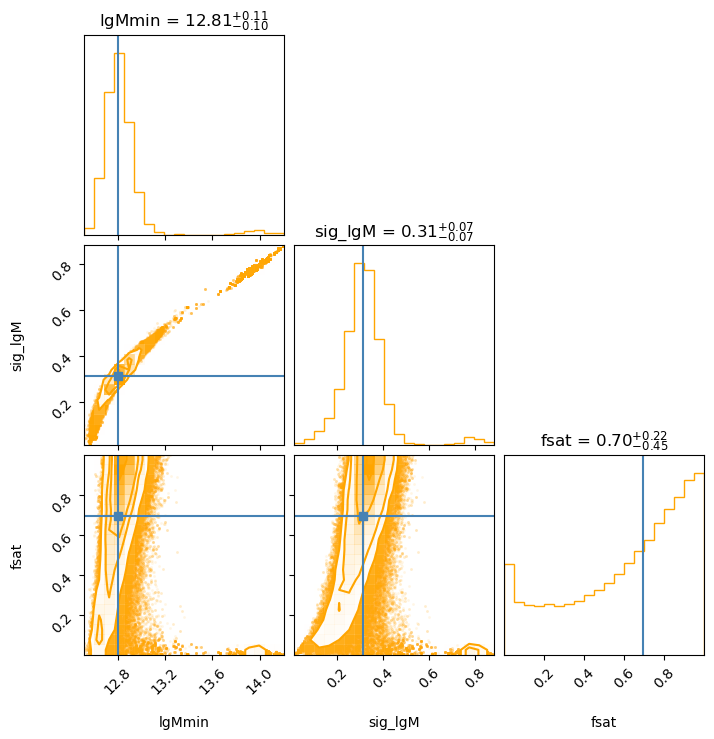

In [11]:
fig = corner.corner(array_2d, labels=result.dtype.names, show_titles=True, color='orange', truths=np.percentile(array_2d, 50, axis=0))

In [12]:
par = parameter.full_parameters(np.percentile(array_2d, 50, axis=0))

In [13]:
predict = module.w_p(logM, Nh, par, wp_table_auto, wp_table_cross)
pre_cross = predict[:len(rp_cross)]
pre_auto = predict[len(rp_cross):]
std = np.sqrt([cov[i, i] for i in range(len(signal))])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]

[]

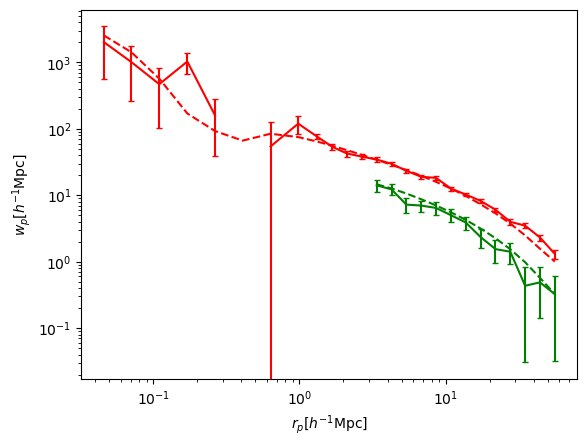

In [14]:
plt.errorbar(rp_auto, signal_auto, err_auto, fmt='r', capsize=2)
plt.errorbar(rp_cross, signal_cross, err_cross, fmt='g', capsize=2)
plt.plot(rp_auto, pre_auto, 'r--')
plt.plot(rp_cross, pre_cross, 'g--')
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
plt.loglog()